# This is a notebook to solve a specific, interesting challenge: there is a riddle hidden in a dataset containing (fake) images of galaxies. 
The challenge is solved in several steps. Step 1. It reads, cleans, classifies the images from the training set. Step 2. It applies the classifier to the test set. Step 3. It performs cluster identification in the projected sky plane and transforms clusters ids into letters to figure out what the hidden message is.

# Setup and definition of some functions

In [1]:
# Common imports

import numpy as np
import os
import pandas as pd
import sklearn
from scipy import ndimage
from skimage import morphology
from sklearn import model_selection
from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
import joblib


# To plot pretty figures

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# General variables and options

ASTRO_DATA_PATH = './dataset/'
binarize_set = 1
illustrate_steps = True


# Functions

def load_astro_data(astro_path,astro_filename):
    
    """ Function to read the dataset
    
        Input: path and filename
        Output: Panda Dataframe
    """
    
    csv_path = os.path.join(astro_path, astro_filename)
    
    return pd.read_csv(csv_path)


def denoise_center_set(dataset):
    
    """ This is a function to (1) remove noise from the images 
        based on a morphological identification (min_size can be tuned)
        and (2) recenter the images (more accurate when done after denoising)
        
        Input: dataset
        Output: modified dataset
        All datasets are of the format (n_instances, n_pixels_in_image)
        a check can be implemented if future datasets are not prepared likewise
    """
    
    # Check the dataset and image size   
    
    n_inst = len(dataset)
    n_x = np.sqrt(len(dataset[0,:])).astype(int)
        
    # Loop on instances of the dataset
    
    for ii in range(n_inst):
    
        # Reshape to an image and remove noise 
        
        this_image = dataset[ii].reshape(n_x,n_x)
        this_image_bool = this_image > 0
        mask_image = morphology.remove_small_objects(this_image_bool,min_size=50)
        this_image_denoise = this_image*mask_image
 
        # Calculate the center of mass and center the image

        center_of_mass_x,center_of_mass_y = ndimage.measurements.center_of_mass(this_image_denoise)
        target_center_x,target_center_y = n_x/2,n_x/2
        new_center = ((target_center_x-center_of_mass_x).astype(int),(target_center_y-center_of_mass_y).astype(int))
        this_image_shifted = np.roll(this_image_denoise,new_center,axis=(0,1))
        dataset[ii] = this_image_shifted.flatten()
    
    return dataset

    
def plot_this_image(this_image,this_title):
    
    """ This is a function to plot the image.
    
        Input: image and plot title 
    """

    n_x = np.sqrt(len(this_image)).astype(int)
    image_reshaped = this_image.reshape(n_x, n_x)
    
    plt.imshow(image_reshaped)
    plt.axis("off")
    plt.title(this_title)
    plt.colorbar(orientation='vertical')
    plt.show()

# Part I: read the labeled dataset; inspect, prepare, and train a model on the set. 

The set is composed of images of size 50x50 of 5000 astronomical objects. Images are on the same intensity scale, ranging from 0 to 31. Those objects are galaxies identified by the boolean label 'spiral'. Non-spiral galaxies are elliptical galaxies, i.e. with an elliptical center but without a spiral pattern. The morphology of the galaxies (presence of arms which translate into extent in the images) is a clear indicator of their class. This is a binary classification problem. Given the clear differences in the images, a linear classifier might be sufficient.


In [2]:
# Load the training data and print out general information

training_set = load_astro_data(ASTRO_DATA_PATH,"catalog-01.csv")

if illustrate_steps:
    print(training_set.head())
    print(training_set.info())
    print(training_set.describe())

   spiral  0,0  0,1  0,2  0,3  0,4  0,5  0,6  0,7  0,8  ...  49,40  49,41  \
0   False    0    0    0    0    0    0    0    0    0  ...      0      0   
1    True    0    0    0    0    0    0    0    0    0  ...      0      0   
2    True    0    0    0    0    0    0    0    0    0  ...      0      0   
3    True    0    0    0    0    0    0    0    0    0  ...      0      0   
4   False    0    0    0    0    0    0    0    0    0  ...      0      0   

   49,42  49,43  49,44  49,45  49,46  49,47  49,48  49,49  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 2501 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 2501 entries, spiral to 49,49
dtypes: bool(1), int64(2500)
memory usa

In [3]:
# Extract the images and the response

X_data = training_set.drop("spiral",axis=1).to_numpy(dtype=float)
y_data = training_set["spiral"].to_numpy(dtype=float)

# Save one example image before cleaning

if illustrate_steps:
    pick_image = 67
    X_data_one_save = X_data[pick_image].copy()

In [4]:
# Clean training set

X_data = denoise_center_set(X_data)

# Note: all images are already on the same scale.
# Otherwise, include a step here.

# Turn on to optimize the structure identification
#   used in a second step but not initially to keep the method more general

if binarize_set:
    X_data[X_data > 0] = 1

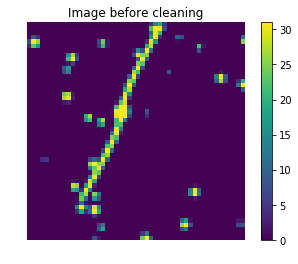

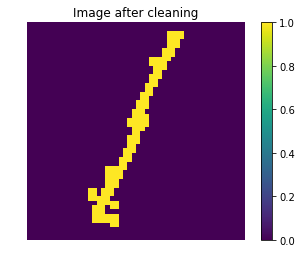

In [5]:
# plot some images for visualization of the training set

if illustrate_steps:
    plot_this_image(X_data_one_save,'Image before cleaning')
    plot_this_image(X_data[pick_image],'Image after cleaning')

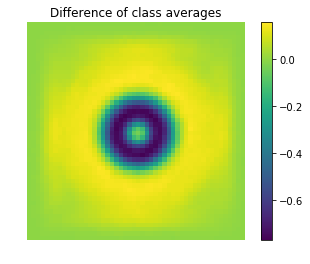

In [6]:
# Optional: plot the difference of the average between the two classes
#  (this step is not necessary but informative)
#   it shows that there are zones in the images that are particularly important for the classification

if illustrate_steps:
    average_spiral = np.mean(X_data[y_data == 1.],axis=0)
    average_nonspiral = np.mean(X_data[y_data == 0.],axis=0)

    plot_this_image(average_spiral-average_nonspiral,'Difference of class averages')

In [7]:
# Separate set into training and validation sets

test_size = 0.5
seed = 0
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_data, y_data, \
                                                            test_size=test_size, random_state=seed)

In [8]:
# Train the model, optimizing the regularization parameter
#  (here, n_instances~n_features, some regularization will be needed)
#   for this linear, binary classification, straightforward Logistic Regression seems sufficient
#    LinearSVC works well too.

log_reg = LogisticRegressionCV(solver="liblinear", cv=3, random_state=42)
log_reg.fit(X_train, y_train)

y_train_pred = cross_val_predict(log_reg, X_train, y_train, cv=3)
y_train_scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring="accuracy")

# Print out performance

print(" == Training set results == ")
print("Scores (accuracy):")
print(y_train_scores)
print("Confusion matrix:")
print(confusion_matrix(y_train, y_train_pred))

 == Training set results == 
Scores (accuracy):
[1. 1. 1.]
Confusion matrix:
[[ 620    0]
 [   0 1880]]


regularization parameter C: 0.005995


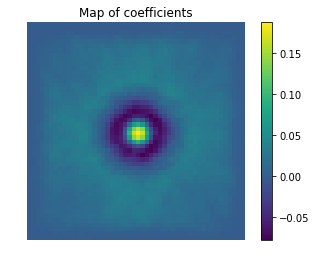

In [9]:
# Check out best value for regularization parameter and fitted coefficients

if illustrate_steps:
    print("regularization parameter C: %f" % (log_reg.C_))
    plot_this_image(log_reg.coef_.flatten(),'Map of coefficients')

# Apply the model to the test set.

In [10]:
# Apply model to make predictions on the test set

y_test_pred = log_reg.predict(X_test)

# Check accuracy with the confusion matrix

print(" == Test set results == ")
print("Confusion matrix:")
print(confusion_matrix(y_test, y_test_pred))

 == Test set results == 
Confusion matrix:
[[ 630    0]
 [   1 1869]]


This seems good in performance. Comparing with the values of cross-validation above, there are slight differences. This could be an indication of over-fitting. However, given the performance on the validation data, the model seems good enough for generalization.

Number of misidendifications: 1
Index, Observed Class, Predicted Class:
677 1.0 0.0


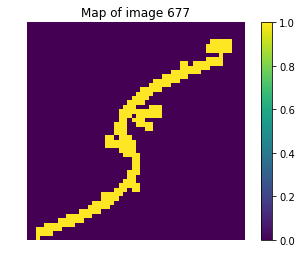

In [11]:
# Check out images for those misidentified

index_mis = np.array(np.where(abs(y_test-y_test_pred) > 0.)).flatten()
print("Number of misidendifications: %i" % (len(index_mis)))

if illustrate_steps & (len(index_mis) > 0):
    print("Index, Observed Class, Predicted Class:")
    for ii in range(len(index_mis)):
        print(index_mis[ii],y_test[index_mis[ii]],y_test_pred[index_mis[ii]])
        plot_this_image(X_test[index_mis[ii]],'Map of image '+str(index_mis[ii]))

The misidentifications appear to be related to spirals with strong centers compared to the arms. The binarize_set option can boost the importance of the arms versus the center and improve the classification.

In [12]:
# Save model for speeding application to future set

if binarize_set:
    joblib.dump(log_reg, 'saved_model_bin.pkl') 
else:
    joblib.dump(log_reg, 'saved_model.pkl') 

# Part II: load the new dataset, prepare it, and apply the model for class prediction

The second set is much larger than the training set. It contains images of 267019 objects. Instances do not have a 'spiral' label but have X and Y position values. The images are of the same kind (same intensity scale, noise) as in the training set so we can prepare them in the same way. Applying the model, we find that only a small fraction of the new dataset appears to have non-spiral objects. Based on the test set, we expect about 1 False Negative out of 1870, hence 150 out of the new dataset. We can tune the decision threshold to reduce the number of False Negatives. Then, we inspect the position of the less-represented class on the sky with the X and Y positions.


In [13]:
# Load saved model

if binarize_set:
    log_reg_load = joblib.load('saved_model_bin.pkl') 
else:
    log_reg_load = joblib.load('saved_model.pkl') 

In [14]:
# Load the new, unlabeled set and print information

new_set = load_astro_data(ASTRO_DATA_PATH,"grlw-145.csv")

if illustrate_steps:
    print(new_set.head())
    print(new_set.info())
    print(new_set.describe())

          x         y  0,0  0,1  0,2  0,3  0,4  0,5  0,6  0,7  ...  49,40  \
0  0.278433 -0.228036    0    0    0    0    0    0    0    0  ...      0   
1 -0.047939  0.070321    0    0    0    0    0    0    0    0  ...      0   
2  0.454666 -0.777126    0    0    0    0    0    0    0    0  ...      0   
3 -0.073506 -0.578250    0    0    0    0    0    0    0    0  ...      0   
4  0.233255 -0.680391    0    0    0    0    0    0    0    0  ...      0   

   49,41  49,42  49,43  49,44  49,45  49,46  49,47  49,48  49,49  
0      0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0      0  
3     16      1      0      0      0      0      0     22     31  
4      0      0      0      0      0      0      0      0      0  

[5 rows x 2502 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267019 entries, 0 to 267018
Columns: 2502 entries, x to 49,4

In [15]:
# Extract and clean dataset

X_new = new_set.drop(["x","y"],axis=1).to_numpy(dtype=float)
x_pos = new_set["x"].to_numpy(dtype=float)
y_pos = new_set["y"].to_numpy(dtype=float)
n_new = len(X_new)

X_new = denoise_center_set(X_new)

if binarize_set:
    X_new[X_new > 0] = 1

In [16]:
# Apply model to make predictions on the test set

y_new_pred = log_reg.predict(X_new)

print("Number of non-spiral: %i / %i, i.e. %f percent " %
      (np.sum(y_new_pred == 0), n_new, np.sum(y_new_pred == 0)/n_new*100.))

Number of non-spiral: 792 / 267019, i.e. 0.296608 percent 


The two classes are clearly not present in the new dataset in equal proportions. There are a lot more spirals than nonspirals. This means that the influence of false negatives is very important. This is the reason to inspect the dependance of the number of galaxies as a function of the probability decision threshold.

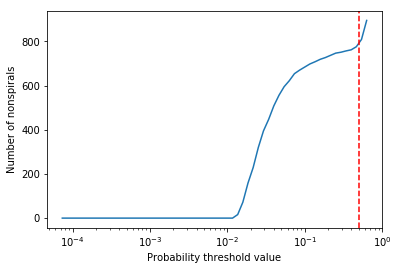

In [17]:
# Get probabilities and tune the threshold

y_new_proba = log_reg.predict_proba(X_new)

if y_new_proba.ndim == 2:
    y_new_proba = y_new_proba[:, 1]
    
# plot nb versus threshold

n_thresholds = 60
thresholds = 10**(-4*np.arange(n_thresholds)/n_thresholds-0.2)
nb_nonspiral = np.zeros(n_thresholds)

for kt,this_threshold in enumerate(thresholds):
    nb_nonspiral[kt] = (y_new_proba < this_threshold).sum()
    
plt.plot(thresholds,nb_nonspiral)
plt.axvline(x=0.5,color='r', linestyle='--')
plt.xscale('log')
plt.xlabel('Probability threshold value')
plt.ylabel('Number of nonspirals')
plt.show()

# apply threshold
#   (the point of inflexion is where the number of false negatives start to dominate the trend)

if binarize_set:
    y_new_proba = (y_new_proba >= 0.5).astype(int)
else:
    y_new_proba = (y_new_proba >= 0.05).astype(int)
    print("Number of non-spiral after thresholding: %i / %i, i.e. %f percent " %
      (np.sum(y_new_proba == 0), n_new, np.sum(y_new_proba == 0)/n_new*100.))

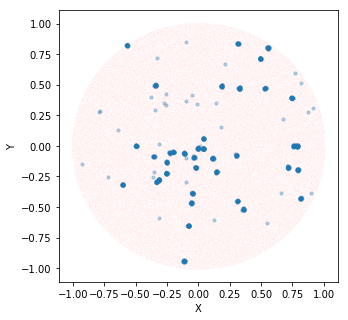

In [18]:
# Check out where the non-spirals fall on the sky

x_nonspiral = x_pos[y_new_proba == 0]
y_nonspiral = y_pos[y_new_proba == 0]

plt.figure(figsize=(5,5))
plt.scatter(x_pos,y_pos,alpha=0.01,s=0.1,color='r')
plt.scatter(x_nonspiral,y_nonspiral,alpha=0.3,s=10)
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Looking at the sources in the X-Y plane, non-spirals are clearly not falling on random places on the plot. They are grouped with each other in clusters and along specific directions. Visual inspection of the images confirms that isolated dots are indeed False Negatives and larger dots are clusters of (about 10) non-spirals.

# Part 3: identify clusters, sort them and match letters
Some clusters are close to each other and real clusters have at least 7-8 members, so identification by agglomeration, i.e. selecting a small radius from the centers, seems appropriate. Computing the frequency of the lines in the X-Y plane, the circles seems divided into 26 parts, i.e. 26 letters. We finally sort the clusters by radius and attribute a most likely letter, given their position in the X-Y plane, by checking the frequency against a corpus, to figure out the meaning of the hidden sentence.

In [19]:
# get the clusters !

from sklearn.cluster import AgglomerativeClustering

xy_array = np.column_stack((x_nonspiral,y_nonspiral))

km = AgglomerativeClustering(n_clusters=None,distance_threshold=0.04)
km = km.fit(xy_array)

In [20]:
# select real clusters
#  by throwing out those with single or few members

n_gals = []
x_cen = []
y_cen = []
for kk in range(km.n_clusters_):
    iio = np.argwhere(km.labels_ == kk)
    if len(iio) > 3:
        n_gals.append(len(iio))
        x_cen.append(np.median(xy_array[iio,0]))
        y_cen.append(np.median(xy_array[iio,1]))
n_clust = len(n_gals)
x_cen = np.array(x_cen)
y_cen = np.array(y_cen)
r_cen = np.sqrt(x_cen**2.+y_cen**2.)

print('N clusters: %i' % n_clust)

N clusters: 38


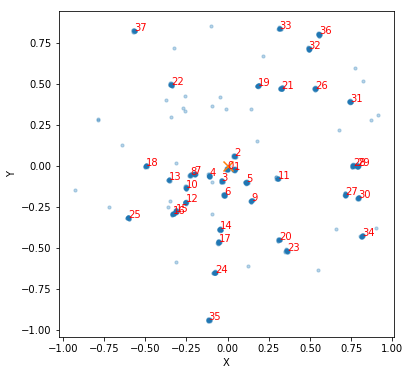

In [21]:
# sort by radius

id_sort = np.argsort(r_cen)
r_cen = r_cen[id_sort]
x_cen = x_cen[id_sort]
y_cen = y_cen[id_sort]

# plot

if illustrate_steps:
    plt.figure(figsize=(6,6))
    plt.scatter(x_nonspiral,y_nonspiral,alpha=0.3,s=10)
    plt.scatter(0,0,s=100,marker='x')
    for i in range(n_clust):
        plt.text(x_cen[i], y_cen[i], str(i),color='r')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

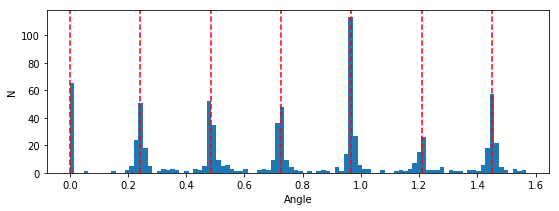

Number of sectors in the whole disk:  26.0


In [22]:
# get the frequency of the pattern
#  the frequency can be seen by eye, but otherwise
#  we can get the accurate value with, e.g. an FFT

theta_arr = np.arctan(np.abs(y_nonspiral/x_nonspiral))
rad_arr = np.sqrt(x_nonspiral**2. + y_nonspiral**2.)

# plot theta

plt.figure(figsize=(9,3))
plt.hist(theta_arr,bins=100)
plt.ylabel('N')
for i in range(7):
    plt.axvline(x=0.2418*i,color='r', linestyle='--')
plt.xlabel('Angle')
plt.show()

print('Number of sectors in the whole disk: ', 2*np.round(np.pi/0.2418))


In [23]:
# get letter-number order from theta

theta_arr = np.arctan(y_cen/x_cen)*180./np.pi
theta_arr[x_cen<0] += 180.
theta_arr[(x_cen>=0) & (y_cen<0)] += 360.

# small shift added to be sure that we are not cutting through a line of clusters
letter_arr = np.floor(theta_arr*26/360. -0.5)
letter_arr = letter_arr.astype(int)

In [24]:
# get most common letter-numbers

letter_unique = np.unique(letter_arr,return_counts=True)
letter_counts = np.array(letter_unique[1])
letter_unique = np.array(letter_unique[0])

id_sort = np.flip(np.argsort(letter_counts))
letter_counts = letter_counts[id_sort]
letter_freq = letter_counts/np.sum(letter_counts)
letter_unique = letter_unique[id_sort]

In [25]:
# compare to corpus-frequency
#  and attribute a score (adding frequencies from
#   the corpus if letter present in the sentence, 
#   not very robust but it works)

alphabet = []
for letter in range(97,123):
    alphabet.append(chr(letter))

corpus = ['e','t','a','o','i','n','s','r','h','l','d']
corpus_p = [4,19,0,14,8,13,18,17,7,11,3]
corpus_f = [0.13,0.09,0.08,0.08,0.08,0.07,0.07,0.06,0.05,0.04,0.04]

scores = np.zeros(len(corpus_p))
sentences = []
for jj,kk in enumerate(corpus_p):
    alphabet_shift = np.roll(alphabet,letter_unique[0]-kk)
    this_sentence = alphabet_shift[letter_arr]
    sentences.append(this_sentence)
    this_letters = alphabet_shift[letter_unique]
    this_score = [corpus_f[i] for (i,v) in enumerate(corpus) if v in this_letters]
    scores[jj] = np.sum(this_score)

In [26]:
# print the sentence with biggest score

most_likely_sentence = ''.join(sentences[np.argmax(scores)])
print('Et voila:')
print(most_likely_sentence)

Et voila:
inthemiddleofdifficultyliesopportunity


# end of the challenge

Thoughts for improvement:
- more robust treatment of noise and background. For example, we could label regions and keep only the largest one.
- more robust classification (less sensitive to above treatment, or if the size of the object varies too much). For example, CNN. Or AutoEncoder that first trains on the whole set and then on the labeled data for classification. But this seems an overkill for the task.
- classes are clearly not present in the same proportions in the training set and in the new set. If future sets are all like the new set, we could think of boosting the training set with more images of spirals.
